# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

### 連續型特徵離散化
雖然由之前的分析發現 DAYS_BIRTH 與 TARGET 的相關係數只有 -0.003，
但在往後的課程裡，為了實際解決問題，我們將需透過一些處理方法，改善相關係數。
目前我們先以對資料的常識理解，去觀察這兩個欄位的交叉狀況。
依照常理,收入越高的人還款能力應該越好,理論上較不會出現違約的狀況!
但特徵離散化時,劃分區間是個重大影響因素

In [5]:
#'AMT_INCOME_TOTAL' 的統計描述吧 (pandas.describe())
print("Correlation between TARGET and AMT_CREDIT",app_train['AMT_INCOME_TOTAL'].corr(app_train['TARGET']))
(app_train['AMT_INCOME_TOTAL']/10e+4).describe()

Correlation between TARGET and AMT_CREDIT -0.003981865601205655


count    307511.000000
mean          1.687979
std           2.371231
min           0.256500
25%           1.125000
50%           1.471500
75%           2.025000
max        1170.000000
Name: AMT_INCOME_TOTAL, dtype: float64

將兩預測資料另存為dataframe,並將'AMT_INCOME_TOTAL'轉換為萬元單位

In [6]:
df_CREDIT_DATA = app_train[['AMT_INCOME_TOTAL','TARGET']]
df_CREDIT_DATA['AMT_INCOME_TOTAL']=df_CREDIT_DATA['AMT_INCOME_TOTAL']/10e+4

D:\Anaconda\envs\leakage\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


可以發現,在收入欄位中,前75%差異不大,後75%才開始往上增加
若根據describle製作bins,將會導致大部分分組都位於前75%,還款能力並沒有顯著差異,造成遞減趨勢不明(可以用bins = [0,0.4,0.8,1.2,1.6.2.0,1170]嘗試)
為了符合現實,必須將考慮到收入位於前25%,並將其分組,才能看出還款能力差異,因此使用bins = [0,2,4,6,8,1500]

In [ ]:
df_CREDIT_DATA['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(1000)

In [7]:
bins = [0,2,4,6,8,1500]
df_CREDIT_DATA['AMT_INCOME_TOTAL'] = pd.cut(df_CREDIT_DATA['AMT_INCOME_TOTAL'],bins=bins)
df_CREDIT_DATA.head(10)

D:\Anaconda\envs\leakage\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,AMT_INCOME_TOTAL,TARGET
0,"(2, 4]",1
1,"(2, 4]",0
2,"(0, 2]",0
3,"(0, 2]",0
4,"(0, 2]",0
5,"(0, 2]",0
6,"(0, 2]",0
7,"(2, 4]",0
8,"(0, 2]",0
9,"(0, 2]",0


In [8]:
# 依照組別彙整收入資料 "每一欄的平均值"
credir_groups  = df_CREDIT_DATA.groupby('AMT_INCOME_TOTAL').mean()
credir_groups

,TARGET
AMT_INCOME_TOTAL,
"(0, 2]",0.084478
"(2, 4]",0.072710
"(4, 6]",0.060564
"(6, 8]",0.043647
"(8, 1500]",0.055556


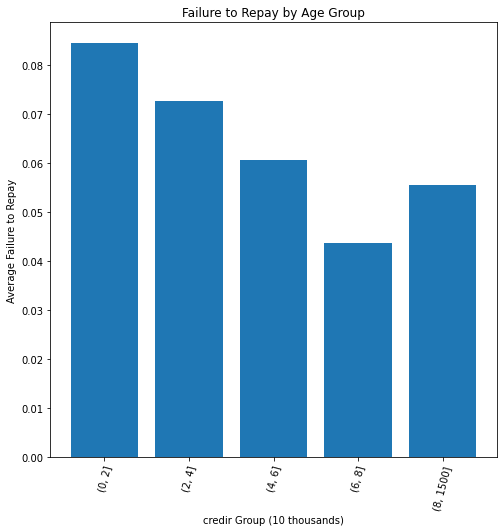

In [9]:
plt.figure(figsize = (8, 8))

# 繪製目標值平均與分組組別的長條圖
plt.bar(range(len(credir_groups.index)), credir_groups['TARGET'])
# 加上 X, y 座標說明, 以及圖表的標題
plt.xticks(range(len(credir_groups.index)), credir_groups.index, rotation = 75); plt.xlabel('credir Group (10 thousands)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Age Group');

可以非常明顯地看出趨勢，收入越低的客戶群組違約的可能性較大，但為了更好的呈現趨勢,可考慮去除離群值
